In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
import numpy as np 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121
#from google.colab import drive #Google colab için
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

In [20]:
def combine(models):
    a = models[0]
    b = models[1]
    concatenate = Concatenate()([a.layers[-3].output,b.layers[-3].output])
    x = Dense(512, activation = 'relu')(concatenate)
    x = Dropout(0.4)(x)
    output = Dense(1)(x)
    model_concat = Model(a.input, output)
    return model_concat

In [9]:
def ensemble(models):
    input = tf.keras.Input(shape=(512, 512, 3))
    
    outputs = [model(input) for model in models]
    y = Average()(outputs)
    
    model = Model(inputs=input,outputs = y, name='combined')
    return model

In [3]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.0,-0.2))
])

In [4]:
pretrained_model_vgg = VGG16(weights='imagenet',include_top=False ,input_shape=(512,512,3))
pretrained_model_dense = DenseNet121(weights='imagenet',include_top=False ,input_shape=(512,512,3))

In [5]:
prediction_layer = tf.keras.layers.Dense(1)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
inputs = tf.keras.Input(shape=(512, 512, 3))
x = data_augmentation(inputs)
x = pretrained_model_vgg(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs_1 = prediction_layer(x)
m_1=Model(inputs,outputs_1)
pretrained_model_vgg.trainable = True
fine_tune_at = 9
for layer in pretrained_model_vgg.layers[:fine_tune_at]:
  layer.trainable =  False

x = data_augmentation(inputs)
x = pretrained_model_dense(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=512,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs_2 = prediction_layer(x)
pretrained_model_dense.trainable = True
fine_tune_at = 200
for layer in pretrained_model_dense.layers[:fine_tune_at]:
  layer.trainable =  False
m_2 = Model(inputs,outputs_2)

In [6]:
m_1.load_weights('./models/teknofestvggnet.h5')
m_2.load_weights('./models/teknofestdensenet.h5')
m_1.trainable = False
m_2.trainable= False

In [21]:
models = [m_1,m_2]
m = combine(models)
n = ensemble(models)

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 512, 512, 3)  0           input_38[0][0]                   
                                                                 input_38[0][0]                   
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 16, 16, 512)  14714688    sequential_12[0][0]              
__________________________________________________________________________________________________
densenet121 (Functional)        (None, 16, 16, 1024) 7037504     sequential_12[1][0]       

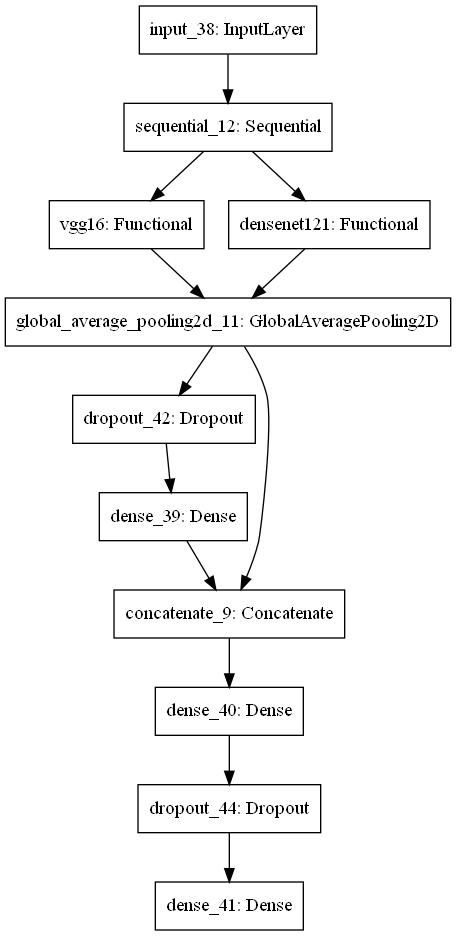

In [161]:
m.summary()
tf.keras.utils.plot_model(m, to_file='model.png')

In [11]:

train_normal_dir=os.path.join('./data/train/normal')
train_PNEUMONIA_dir=os.path.join('./data/train/anormal')
test_normal_dir=os.path.join('./data/test/normal')
test_PNEUMONIA_dir=os.path.join('./data/test/anormal')
val_normal_dir=os.path.join('./data/val/normal')
val_PNEUMONIA_dir=os.path.join('./data/val/anormal')

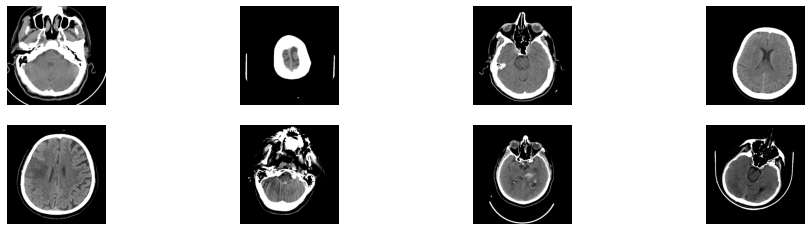

In [12]:
nrows=2
ncols=4

pic_index=0

fig=plt.gcf()
fig.set_size_inches(ncols*4,nrows*2)

pic_index+=4

next_normal_pix = [os.path.join(train_normal_dir,fname) for fname in os.listdir(train_normal_dir)[pic_index-4:pic_index]]
next_pne_pix = [os.path.join(train_PNEUMONIA_dir,fname) for fname in os.listdir(train_PNEUMONIA_dir)[pic_index-4:pic_index]]

for i, img_path in enumerate(next_normal_pix+next_pne_pix):
  sp=plt.subplot(nrows,ncols,i+1)
  sp.axis('Off')
  img=mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

In [13]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 10
train_datagen = ImageDataGenerator(rescale = 1./255)

train_generator=train_datagen.flow_from_directory(
      './data/train/',
      target_size=(512,512),
      batch_size=BATCH_SIZE,
      class_mode='binary'
)
train_dataset = image_dataset_from_directory('./data/train/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=(512,512))


test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=train_datagen.flow_from_directory(
      './data/test/',
      target_size=(512,512),
      batch_size=BATCH_SIZE,
      class_mode='binary',
      shuffle=True
)
test_dataset = image_dataset_from_directory('./data/test/',
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=(512,512))

val_datagen=ImageDataGenerator(rescale=1./255)
val_generator=train_datagen.flow_from_directory(
      './data/val/',
      target_size=(512,512),
      batch_size=BATCH_SIZE,
      class_mode='binary'
)
validation_dataset = image_dataset_from_directory('./data/val/',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=(512,512))



Found 6356 images belonging to 2 classes.
Found 6356 files belonging to 2 classes.
Found 140 images belonging to 2 classes.
Found 140 files belonging to 2 classes.
Found 140 images belonging to 2 classes.
Found 140 files belonging to 2 classes.


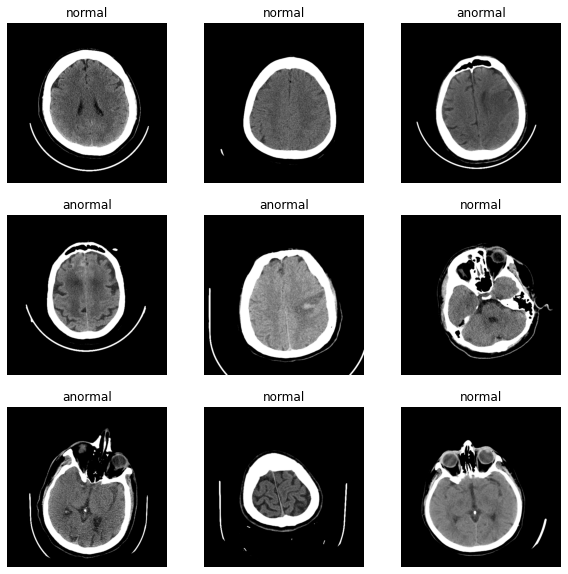

In [165]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [166]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

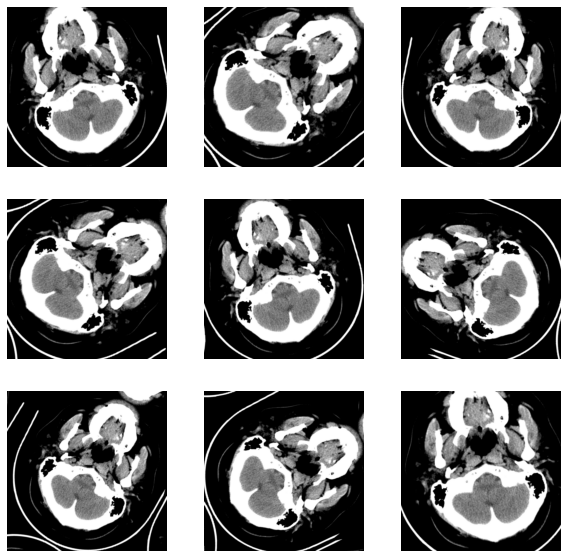

In [167]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [168]:
base_learning_rate = 0.0001
m.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [169]:
history = m.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset)


Epoch 1/5
636/636 [==============================] - 346s 532ms/step - loss: 0.1333 - accuracy: 0.9484 - val_loss: 0.2771 - val_accuracy: 0.9214
Epoch 2/5
636/636 [==============================] - 343s 539ms/step - loss: 0.0932 - accuracy: 0.9670 - val_loss: 0.2836 - val_accuracy: 0.9214
Epoch 3/5
636/636 [==============================] - 343s 539ms/step - loss: 0.0941 - accuracy: 0.9660 - val_loss: 0.2824 - val_accuracy: 0.9286
Epoch 4/5
636/636 [==============================] - 343s 540ms/step - loss: 0.0874 - accuracy: 0.9665 - val_loss: 0.2699 - val_accuracy: 0.9286
Epoch 5/5
636/636 [==============================] - 345s 542ms/step - loss: 0.0777 - accuracy: 0.9701 - val_loss: 0.2654 - val_accuracy: 0.9214


In [170]:
loss0, accuracy0 = m.evaluate(validation_dataset)

14/14 [==============================] - 7s 512ms/step - loss: 0.2654 - accuracy: 0.9214


In [171]:
m.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [172]:
loss0, accuracy0 = m.evaluate(test_dataset)

14/14 [==============================] - 52s 481ms/step - loss: 0.1913 - accuracy: 0.9429


In [173]:
m.save('./models/fullyconnected_dense+vgg.h5')

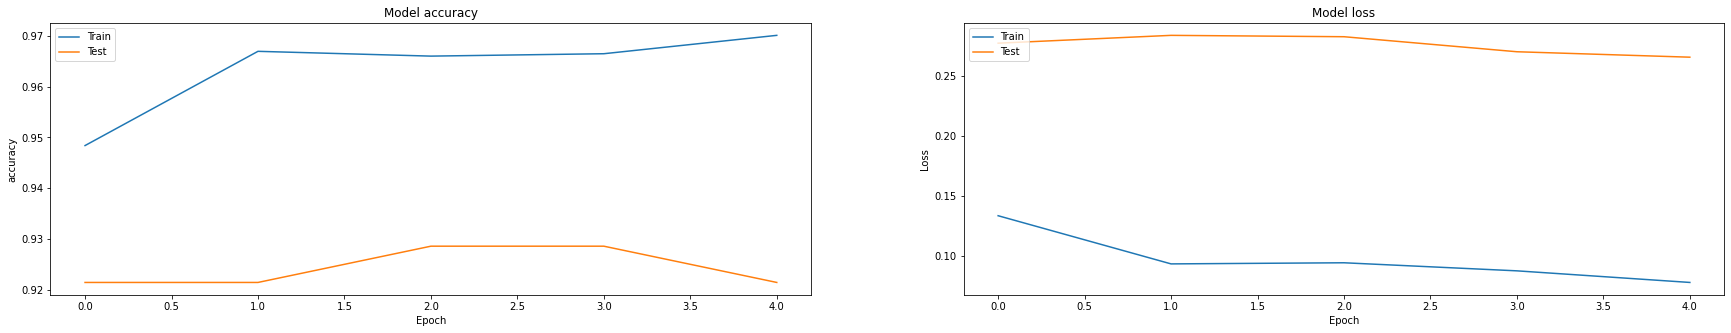

In [174]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
n.compile(optimizer=tf.keras.optimizers.Adam(lr=10/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
n.evaluate(test_dataset)
n.evaluate(validation_dataset)

14/14 [==============================] - 7s 489ms/step - loss: 0.3375 - accuracy: 0.8143


[0.3375423848628998, 0.8142856955528259]

In [22]:
m.load_weights('./models/fullyconnected_dense+vgg.h5')